In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

In [97]:
data = pd.read_csv("news.csv")

In [93]:
data.head()

,text,label
0,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,It's primary day in New York and front-runners...,REAL


In [4]:
data.shape

(6335, 4)

In [ ]:
data.isnull().sum()

<Axes: xlabel='label', ylabel='count'>

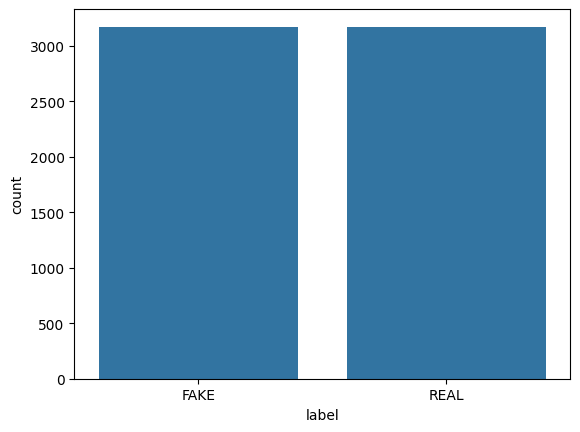

In [106]:
sns.countplot(x = data.label)

In [110]:
def preprocess_text(text_data):
    preprocessed_text = []
    
    for sentence in tqdm(text_data):
        sentence = re.sub(r'[^\w\s]', '', sentence)
        preprocessed_text.append(' '.join(token.lower()
                                  for token in str(sentence).split()
                                  if token not in stopwords.words('english')))

    return preprocessed_text


In [111]:
preprocessed_review = preprocess_text(data['text'].values)
data['text'] = preprocessed_review

100%|██████████| 6335/6335 [19:23<00:00,  5.44it/s] 


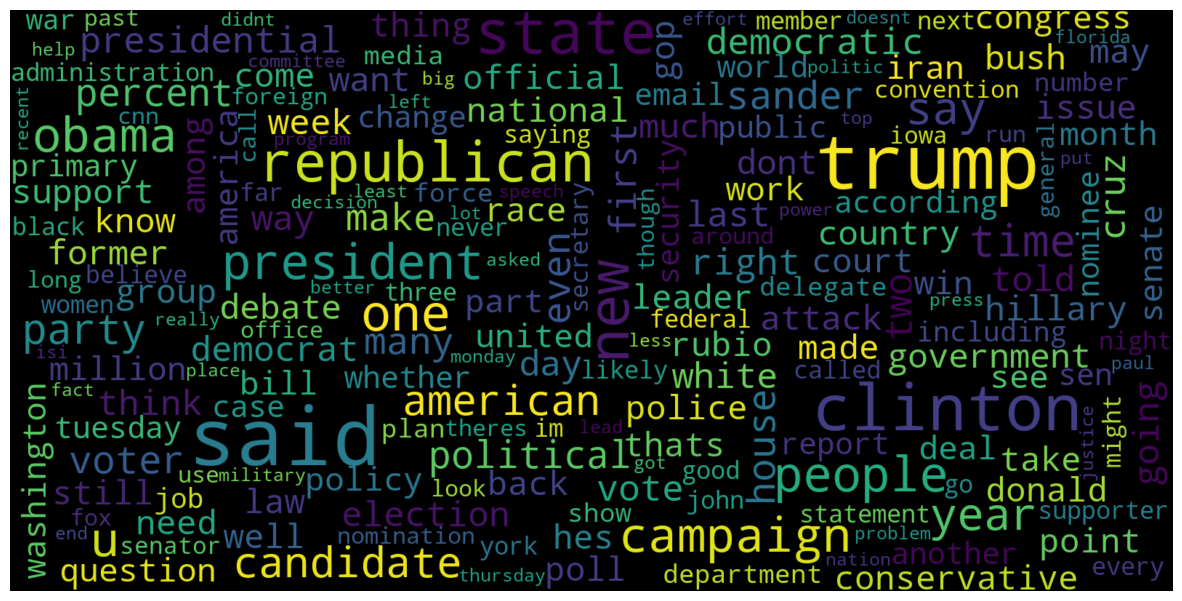

In [116]:
# Real
consolidated = ' '.join(
    word for word in data['text'][data['label'] == 'REAL'].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()


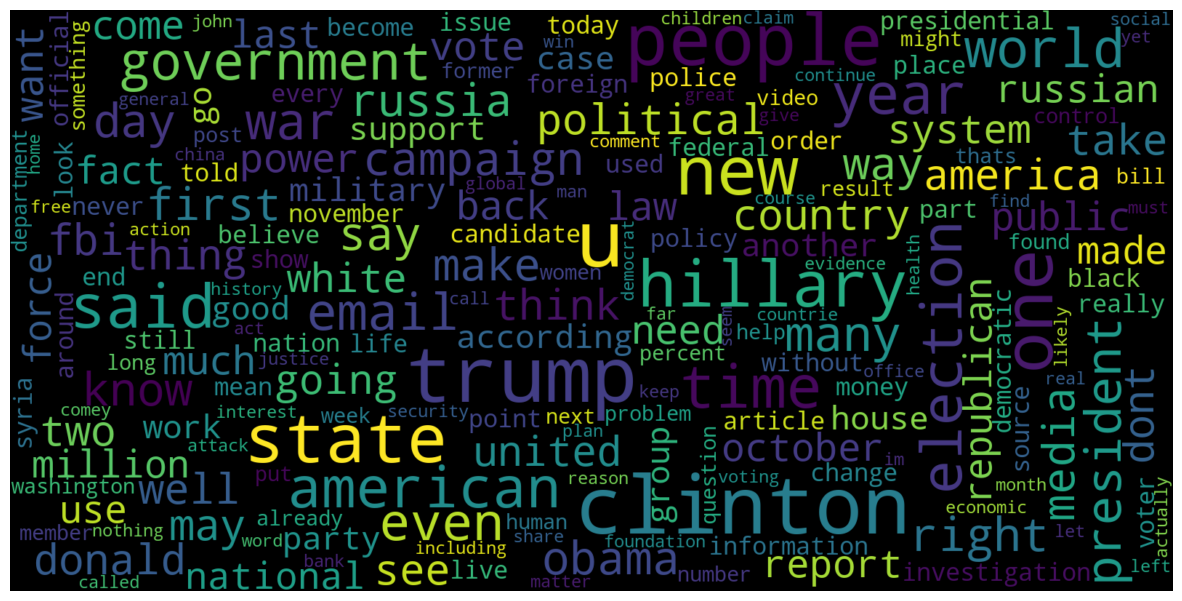

In [118]:
# Fake
consolidated = ' '.join(
    word for word in data['text'][data['label'] == 'FAKE'].astype(str))
wordCloud = WordCloud(width=1600,
                      height=800,
                      random_state=21,
                      max_font_size=110,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(consolidated), interpolation='bilinear')
plt.axis('off')
plt.show()

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

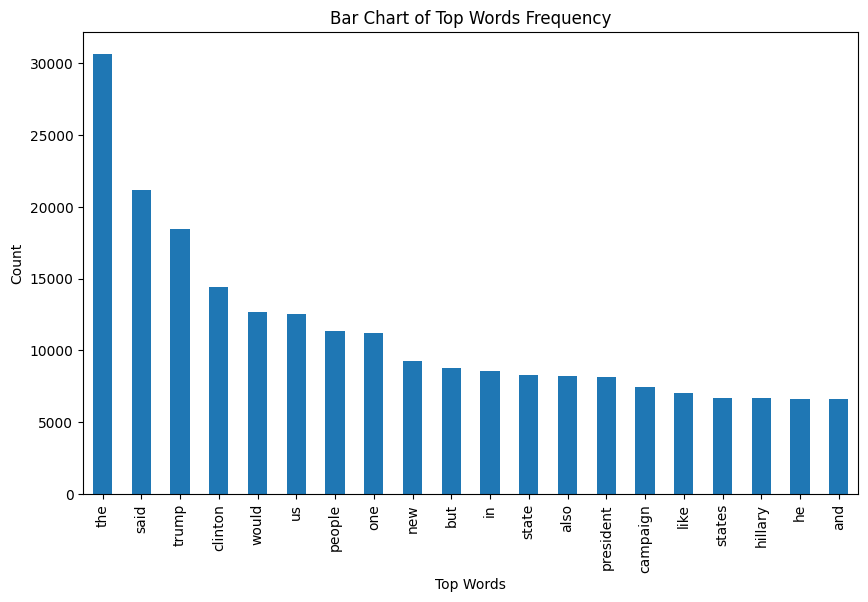

In [126]:
from sklearn.feature_extraction.text import CountVectorizer


def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(data['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])

df1.groupby('Review').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
)


In [98]:
x = data['text']
y = data['label']

In [99]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [82]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)

tfidf_train = tfidf_vectorizer.fit_transform(x_train)
tfidf_test = tfidf_vectorizer.transform(x_test)

#### Passive Aggressive Classifier

In [127]:
pac = PassiveAggressiveClassifier(max_iter=50, random_state=42)
pac.fit(tfidf_train, y_train)

pred = pac.predict(tfidf_test)
print(accuracy_score(y_test, pred))
confusion_matrix(y_test, pred, labels=["REAL", "FAKE"])

0.9374013677012099


array([[868,  65],
       [ 54, 914]])

#### Decision Tree Classifier


In [122]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(tfidf_train, y_train)

pred = dt.predict(tfidf_test)
print(accuracy_score(y_test, pred))
confusion_matrix(y_test, pred, labels=["REAL", "FAKE"])

0.8148342977380326


array([[766, 167],
       [185, 783]])

#### Random Forest Classifier


In [123]:
rf = RandomForestClassifier(random_state=42)
rf.fit(tfidf_train, y_train)

pred = rf.predict(tfidf_test)
print(accuracy_score(y_test, pred))
confusion_matrix(y_test, pred, labels=["REAL", "FAKE"])

0.9084692267227775


array([[841,  92],
       [ 82, 886]])

#### Gradient Boost Classifier

In [124]:
gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(tfidf_train, y_train)

pred = gbc.predict(tfidf_test)
print(accuracy_score(y_test, pred))
confusion_matrix(y_test, pred, labels=["REAL", "FAKE"])

0.8879537085744345


array([[809, 124],
       [ 89, 879]])

#### Ensemble Model with Voting Classifier

In [129]:
# Create a VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('pac', pac),
        ('rf', rf),
        ('gbc', gbc)
    ],
    voting='hard'  # Use 'hard' for majority voting or 'soft' for weighted probabilities
)

In [131]:
# Fit the VotingClassifier on the training data
voting_clf.fit(tfidf_train, y_train)

# Evaluate the model
pred = voting_clf.predict(tfidf_test)
accuracy_score(y_test, pred)

0.9268805891635981